<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [1]:
!python --version

Python 3.9.1


In [18]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Block Building

In [27]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

In [20]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [21]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.3652 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

#### EmbeddingsNNBlockBuilding

In [30]:
emb = EmbeddingsNNBlockBuilding(vectorizer='roberta',
                                similarity_search='faiss')
blocks = emb.build_blocks(data)

Embeddings-NN Block Building:   0%|          | 0/2152 [00:00<?, ?it/s]

D1: Started tokenization


In [28]:
blocks

{1076: {11,
  25,
  38,
  47,
  70,
  93,
  94,
  96,
  100,
  106,
  137,
  159,
  216,
  219,
  293,
  344,
  420,
  423,
  434,
  584,
  657,
  658,
  779,
  794,
  799,
  851,
  889,
  1009,
  1020,
  1026},
 1077: {11,
  25,
  26,
  38,
  44,
  47,
  70,
  100,
  101,
  106,
  127,
  128,
  159,
  216,
  219,
  230,
  257,
  344,
  420,
  423,
  434,
  657,
  658,
  779,
  799,
  851,
  889,
  1009,
  1020,
  1026},
 1078: {25,
  38,
  70,
  93,
  94,
  100,
  106,
  120,
  127,
  128,
  143,
  230,
  257,
  293,
  420,
  422,
  423,
  434,
  536,
  584,
  657,
  779,
  794,
  795,
  799,
  851,
  889,
  953,
  1009,
  1020},
 1079: {25,
  26,
  38,
  47,
  50,
  76,
  79,
  106,
  143,
  159,
  215,
  219,
  230,
  257,
  293,
  330,
  347,
  384,
  420,
  423,
  434,
  436,
  454,
  536,
  657,
  658,
  731,
  779,
  799,
  1009},
 1080: {11,
  25,
  38,
  47,
  70,
  100,
  106,
  141,
  143,
  215,
  219,
  293,
  306,
  330,
  415,
  420,
  434,
  436,
  584,
  657,
  713,
  

In [26]:
emb.evaluate(blocks, with_classification_report=True)

AttributeError: 'set' object has no attribute 'entities_D1'

# Block Cleaning

In [6]:
from pyjedai.block_cleaning import BlockFiltering

In [7]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [8]:
from pyjedai.block_cleaning import BlockPurging

In [9]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/5016 [00:00<?, ?it/s]

In [10]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 2970.0
Runtime: 0.0431 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.95% 
	Recall:        98.42%
	F1-score:       1.87%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1059
	False positives: 110990
	True negatives: 1046769
	False negatives: 17
	Total comparisons: 112049
──────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 0.9451222233130148,
 'Recall %': 98.42007434944237,
 'F1 %': 1.8722651933701657,
 'True Positives': 1059,
 'False Positives': 110990,
 'True Negatives': 1046769,
 'False Negatives': 17}

## Meta Blocking

In [11]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

In [12]:
wep = CardinalityEdgePruning(weighting_scheme='X2')
candidate_pairs_blocks = wep.process(filtered_blocks, data)

Cardinality Edge Pruning:   0%|          | 0/1076 [00:00<?, ?it/s]

In [40]:
wep.evaluate(candidate_pairs_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Cardinality Edge Pruning
***************************************************************************************************************************
Method name: Cardinality Edge Pruning
Parameters: 
	Node centric: False
	Weighting scheme: X2
Runtime: 6.9578 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      9.37% 
	Recall:        88.75%
	F1-score:      16.95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 955
	False positives: 9240
	True negatives: 1148415
	False negatives: 121
	Total comparisons: 10195
────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 9.367336929867582,
 'Recall %': 88.7546468401487,
 'F1 %': 16.946144973826634,
 'True Positives': 955,
 'False Positives': 9240,
 'True Negatives': 1148415,
 'False Negatives': 121}

# Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [14]:
from pyjedai.matching import EntityMatching

In [15]:
EM = EntityMatching(
    metric='dice',
    similarity_threshold=0.4,
    attributes = ['description', 'name']
)

pairs_graph = EM.predict(candidate_pairs_blocks, data, tqdm_disable=True)

In [ ]:
# pairs = write(pairs_graph, data)

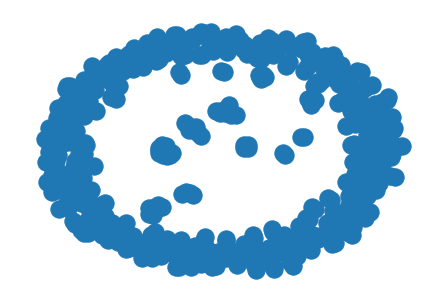

In [16]:
draw(pairs_graph)

In [17]:
EM.evaluate(pairs_graph)

***************************************************************************************************************************
                                         Μethod:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Metric: dice
	Embeddings: None
	Attributes: ['description', 'name']
	Similarity threshold: 0.4
Runtime: 2.9832 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     69.72% 
	Recall:        20.54%
	F1-score:      31.73%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 69.71608832807571,
 'Recall %': 20.53903345724907,
 'F1 %': 31.73007896625987,
 'True Positives': 221,
 'False Positives': 96,
 'True Negatives': 1156825,
 'False Negatives': 855}

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [43]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [44]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph, data)

In [ ]:
clusters

In [39]:
ccc.report()

Method name: Connected Components Clustering
Method info: Gets equivalence clusters from the transitive closure of the similarity graph.
Parameters:  None
Runtime: 0.0050 seconds


In [45]:
ccc.evaluate(clusters, with_classification_report=True)

{1244: 0, 295: 0, 389: 1, 1677: 1, 1449: 2, 638: 2, 706: 3, 1947: 3, 1971: 4, 879: 4, 880: 5, 1972: 5, 1075: 6, 1093: 6, 32: 7, 1126: 7, 1172: 8, 93: 8, 2026: 9, 95: 9, 264: 10, 1191: 10, 804: 11, 1487: 11, 1969: 12, 447: 12, 2109: 13, 535: 13, 984: 14, 2132: 14, 238: 15, 1439: 15, 330: 16, 1453: 16, 1018: 17, 1548: 17, 1419: 18, 268: 18, 1360: 19, 397: 19, 2033: 20, 906: 20, 995: 21, 1683: 21, 1561: 22, 1027: 22, 992: 23, 1607: 23, 434: 24, 1078: 24, 573: 25, 1646: 25, 648: 26, 1777: 26, 731: 27, 1948: 27, 801: 28, 1757: 28, 57: 29, 1181: 29, 971: 30, 2036: 30, 1874: 31, 1015: 31, 88: 32, 1125: 32, 2027: 33, 901: 33, 230: 34, 1423: 34, 257: 35, 1385: 35, 496: 36, 1942: 36, 1970: 37, 670: 37, 1456: 38, 851: 38, 370: 39, 1539: 39, 194: 40, 1157: 40, 408: 41, 1526: 41, 1784: 42, 609: 42, 692: 43, 1949: 43, 1381: 44, 949: 44, 1004: 45, 1647: 45, 1016: 46, 1190: 46, 1097: 47, 25: 47, 100: 48, 1102: 48, 288: 49, 1169: 49, 1853: 50, 479: 50, 480: 51, 1852: 51, 482: 52, 1854: 52, 141: 53, 163

{'Precision %': 97.26775956284153,
 'Recall %': 16.54275092936803,
 'F1 %': 28.276409849086576,
 'True Positives': 178,
 'False Positives': 5,
 'True Negatives': 1156873,
 'False Negatives': 898}

In [22]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph, data)

Unique Mapping Clustering can only be performed in Clean-Clean Entity Resolution.


In [23]:
umc.evaluate(clusters, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Unique Mapping Clustering
***************************************************************************************************************************
Method name: Unique Mapping Clustering
Parameters: 
Runtime: 0.0039 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     82.68% 
	Recall:        17.75%
	F1-score:      29.23%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 191
	False positives: 40
	True negatives: 1156851
	False negatives: 885
	Total comparisons: 231
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 82.68398268398268,
 'Recall %': 17.750929368029738,
 'F1 %': 29.227237949502673,
 'True Positives': 191,
 'False Positives': 40,
 'True Negatives': 1156851,
 'False Negatives': 885}